In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Set random seed for reproducibility
sionna.config.seed = 42

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

from utils.options import args_parser
from utils.sumo_utils import read_trajectoryInfo_timeindex

In [2]:
# 设置参数
N_t = 64  # 发射天线数
N_r = 1   # 接收天线数

# 生成 DFT 码本
def generate_dft_codebook(N_t,N_codes=None):
    # 创建 DFT 矩阵
    # 这就是 N_t 个基向量的矩阵，包含 N_t 列，每列是一个 DFT 基向量
    if N_codes==None:
        dft_matrix = np.exp(-1j * 2 * np.pi * np.outer(np.arange(N_t), np.arange(N_t)) / N_t)
    else:
        dft_matrix = np.exp(-1j * 2 * np.pi * np.outer(np.arange(N_t), np.arange(N_codes)) / N_codes)
    return dft_matrix
DFT_matrix = generate_dft_codebook(N_t,N_codes=N_t)
np.angle(DFT_matrix[:,3])

array([ 0.        , -0.29452431, -0.58904862, -0.88357293, -1.17809725,
       -1.47262156, -1.76714587, -2.06167018, -2.35619449, -2.6507188 ,
       -2.94524311,  3.04341788,  2.74889357,  2.45436926,  2.15984495,
        1.86532064,  1.57079633,  1.27627202,  0.9817477 ,  0.68722339,
        0.39269908,  0.09817477, -0.19634954, -0.49087385, -0.78539816,
       -1.07992247, -1.37444679, -1.6689711 , -1.96349541, -2.25801972,
       -2.55254403, -2.84706834, -3.14159265,  2.84706834,  2.55254403,
        2.25801972,  1.96349541,  1.6689711 ,  1.37444679,  1.07992247,
        0.78539816,  0.49087385,  0.19634954, -0.09817477, -0.39269908,
       -0.68722339, -0.9817477 , -1.27627202, -1.57079633, -1.86532064,
       -2.15984495, -2.45436926, -2.74889357, -3.04341788,  2.94524311,
        2.6507188 ,  2.35619449,  2.06167018,  1.76714587,  1.47262156,
        1.17809725,  0.88357293,  0.58904862,  0.29452431])

In [3]:
with open('./sionna_result/trajectoryInfo_500_500.5.pkl', 'rb') as f:
    trajectoryInfo = pickle.load(f)
    
see_scene = 500.5
for veh in trajectoryInfo[see_scene].keys():
    veh_pos = trajectoryInfo[see_scene][veh]['pos']
    veh_h = trajectoryInfo[see_scene][veh]['h']
trajectoryInfo[see_scene].keys()

dict_keys([1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 2.41, 2.42, 2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5, 2.51, 2.52, 2.53, 3.38, 3.39, 3.4, 3.41, 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5, 3.51, 3.52, 3.53, 3.54, 4.28, 4.29, 4.31, 4.32, 4.38, 4.39, 4.4, 4.41, 4.42, 4.43, 4.44, 4.45, 5.29, 5.34, 5.35, 5.36, 5.38, 5.39, 5.41, 5.42, 5.43, 5.44, 5.45, 5.46, 6.35, 6.37, 6.38, 6.39, 6.4, 6.41, 6.42, 6.43, 7.27, 7.3, 7.31, 7.32, 7.33, 7.34, 7.35, 7.36, 7.37, 7.38, 7.39, 7.4, 8.33, 8.34, 8.35, 8.36, 8.39, 8.4, 8.42, 8.43, 8.44, 8.45, 8.46, 8.47])

vehicle num: 582


(array([ 0.95181714, -6.97577395,  7.23865035, -1.22280084]),
 array([ 0.89528299, 69.63586519,  3.5833217 , 79.85820663]))

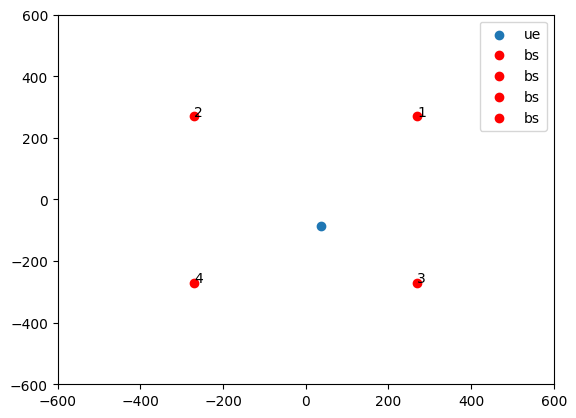

In [4]:
import math
def cal_angle(src,dst,src_face_angle=0):
    aaa = dst-src
    if aaa[0]<0:
        bbb = np.arctan(aaa[1]/aaa[0])/np.pi*180 + 180
    else:
        bbb = np.arctan(aaa[1]/aaa[0])/np.pi*180
    bbb = bbb - src_face_angle
    bbb = bbb % 360
    if bbb > 180:
        bbb -= 360
    return bbb
optimal_beam_list = []
l_bs1=np.array([270,270]).astype(np.float64)
l_bs2=np.array([-270,270]).astype(np.float64)
l_bs3=np.array([270,-270]).astype(np.float64)
l_bs4=np.array([-270,-270]).astype(np.float64)

h_v_t_list = []
l_v_t_list = []
for t in trajectoryInfo.keys():
    _time = time.time()
    for i,(v, v_state) in enumerate(trajectoryInfo[t].items()):
        h_v_t = v_state['h']
        h_v_t_list.append(h_v_t)
        l_v_t = v_state['pos']
        l_v_t_list.append(l_v_t)
        optimal_beam = np.abs(np.dot(h_v_t,DFT_matrix)).argmax(axis=-1)
        optimal_beam_list.append(optimal_beam)
optimal_beam_list = np.array(optimal_beam_list)

plt.figure()
plt.scatter(l_v_t[0],l_v_t[1],label='ue')
plt.scatter(l_bs1[0],l_bs1[1],label='bs',color='r')
plt.text(l_bs1[0],l_bs1[1],'1')
plt.scatter(l_bs2[0],l_bs2[1],label='bs',color='r')
plt.text(l_bs2[0],l_bs2[1],'2')
plt.scatter(l_bs3[0],l_bs3[1],label='bs',color='r')
plt.text(l_bs3[0],l_bs3[1],'3')
plt.scatter(l_bs4[0],l_bs4[1],label='bs',color='r')
plt.text(l_bs4[0],l_bs4[1],'4')
plt.legend()
plt.xlim([-600,600])
plt.ylim([-600,600])
print('vehicle num:',len(h_v_t_list))
see_v_index = 150
# cal_angle(src=l_bs1,dst=l_v_t,src_face_angle=-135), optimal_beam_list[-1,:]
AoDs = cal_angle(src=l_bs1,dst=l_v_t_list[see_v_index],src_face_angle=-135), cal_angle(src=l_bs2,dst=l_v_t_list[see_v_index],src_face_angle=-45), cal_angle(src=l_bs3,dst=l_v_t_list[see_v_index],src_face_angle=135), cal_angle(src=l_bs4,dst=l_v_t_list[see_v_index],src_face_angle=45), 
AoDs = np.array(AoDs)
# wrong: AoOB = optimal_beam_list[see_v_index,:]/N_t*360
AoOB = np.arcsin(optimal_beam_list[see_v_index,:]/N_t)/np.pi*180

AoDs,AoOB

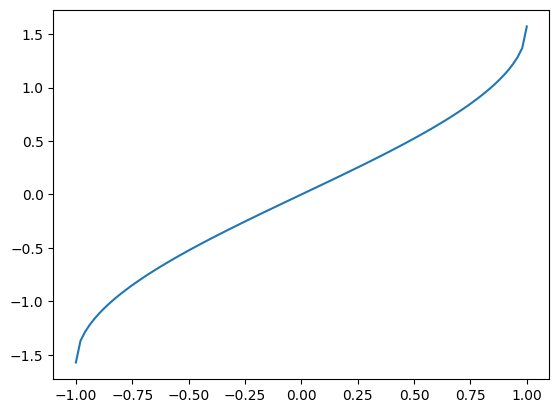

In [5]:
pi = np.pi
xxx = np.linspace(-1,1,100)
yyy = np.arcsin(xxx)
plt.plot(xxx,yyy)

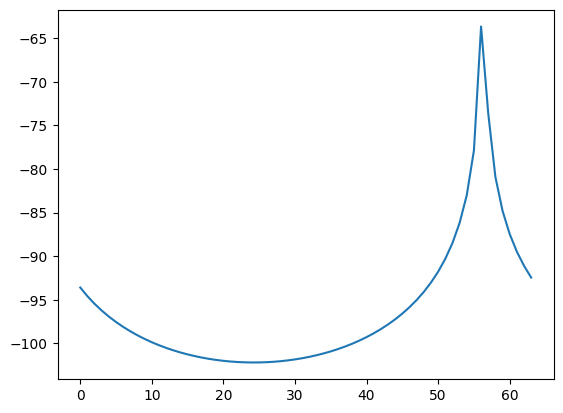

In [6]:
plt.plot(20*np.log10(np.abs(np.dot(h_v_t,DFT_matrix))[3])) # BS-1

[46 48 44 38 34 27 21 22 16  8  5  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  2  9 13 18 24 28 23 41 35 38 42]
[44 53 32 29 34 33 35 19 21 12  2  1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  9 12 19 22 24 32 40 34 38 36]
[44 43 42 32 28 37 25 22 21 15  6  1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  4 16 19 16 27 33 35 33 33 49]
[50 41 35 34 46 29 23 19 16 16  8  3  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  4 12 14 20 32 22 34 35 39 50]


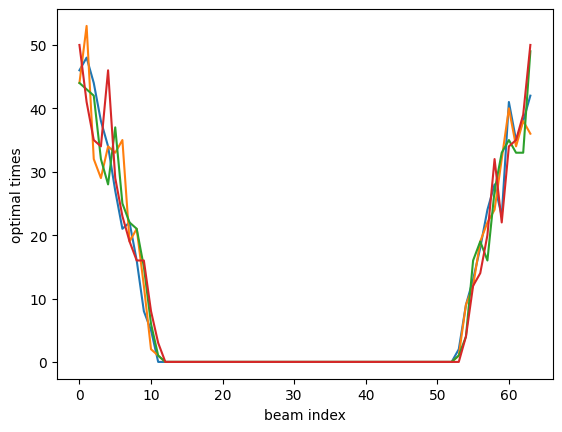

In [7]:

from collections import Counter
# Counter(optimal_beam_list[:,0])
np.bincount(optimal_beam_list[:,0])
plt.figure()
for i in range(4):
    plt.plot(np.bincount(optimal_beam_list[:,i]),label=i)
    print(np.bincount(optimal_beam_list[:,i]))
plt.xlabel('beam index')
plt.ylabel('optimal times')
plt.show()

1.38 [-228.42829293  242.        ]
1.48 [-490.07538288  242.        ]
2.5 [-258.          264.60100006]
3.44 [-277.36537446  251.6       ]
3.54 [242.         383.37960068]
4.43 [266.0432048 251.6      ]
5.42 [ 228.34048413 -242.        ]
6.41 [ -69.58511149 -248.4       ]
7.36 [-248.4          15.47887574]
8.4 [127.61176333 248.4       ]


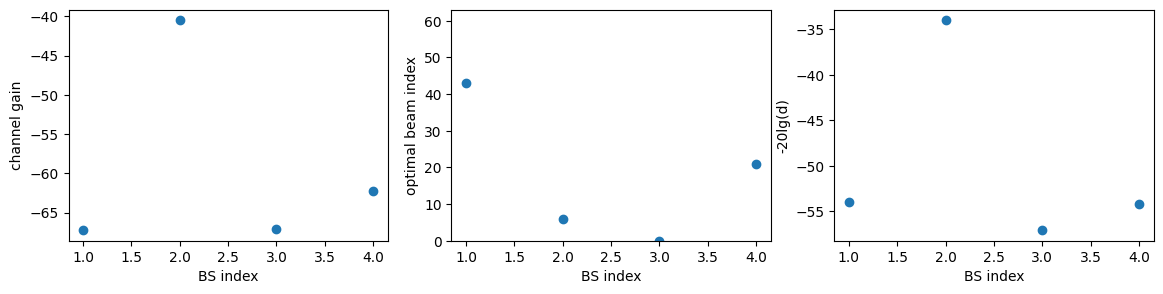

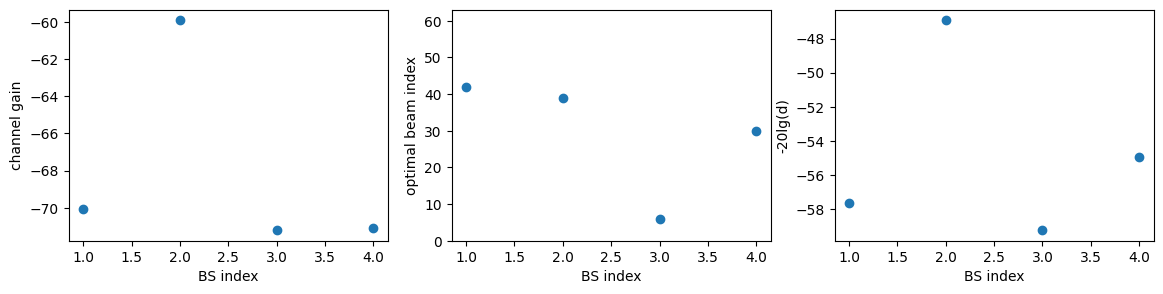

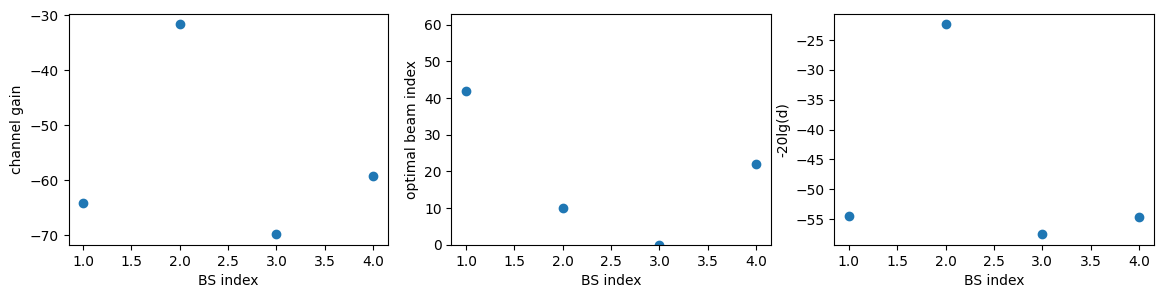

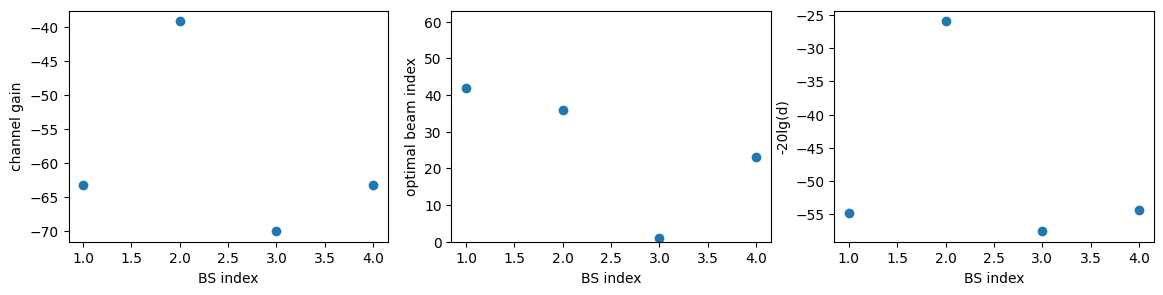

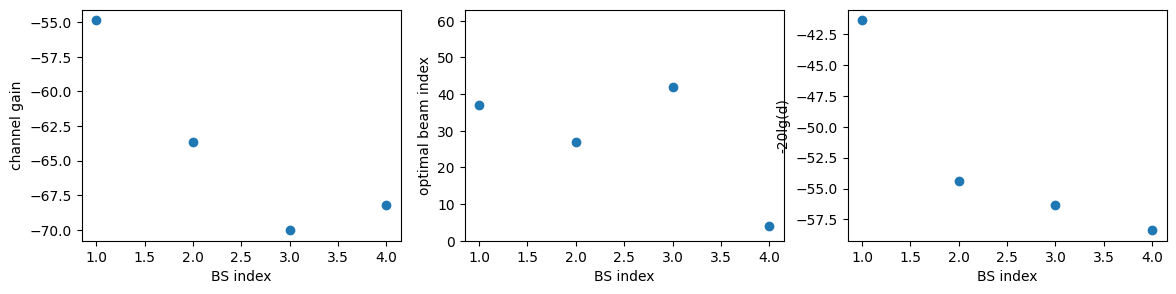

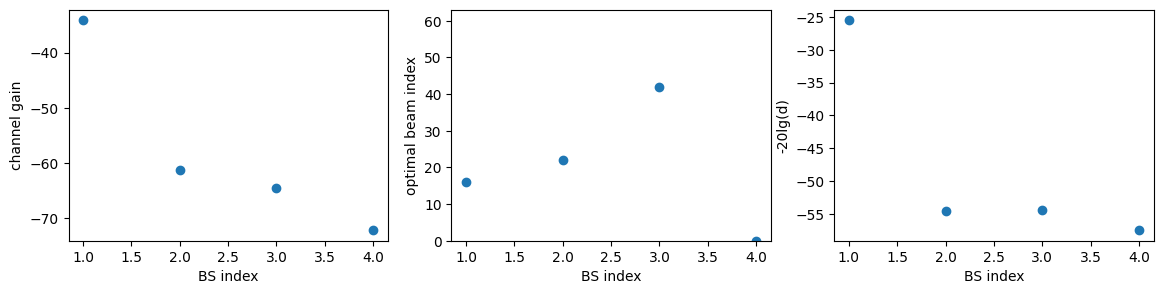

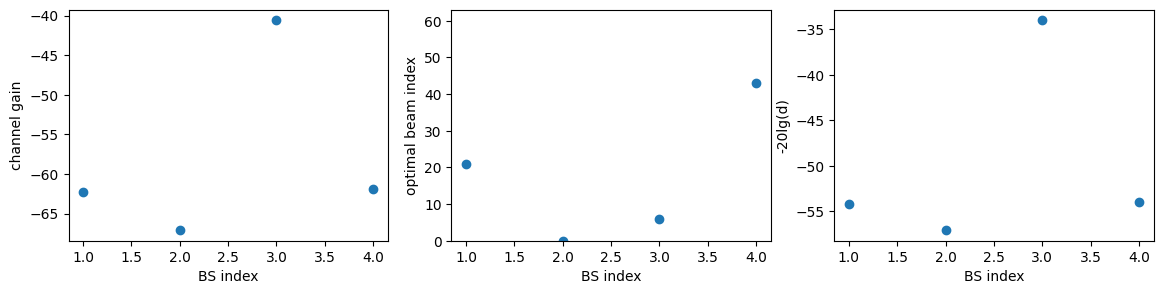

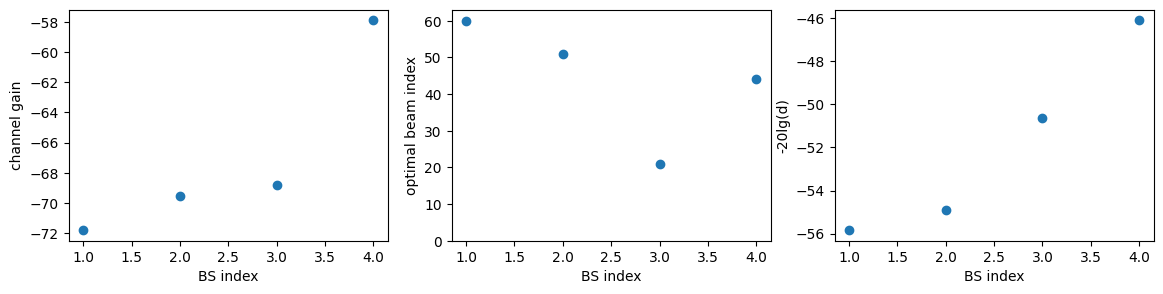

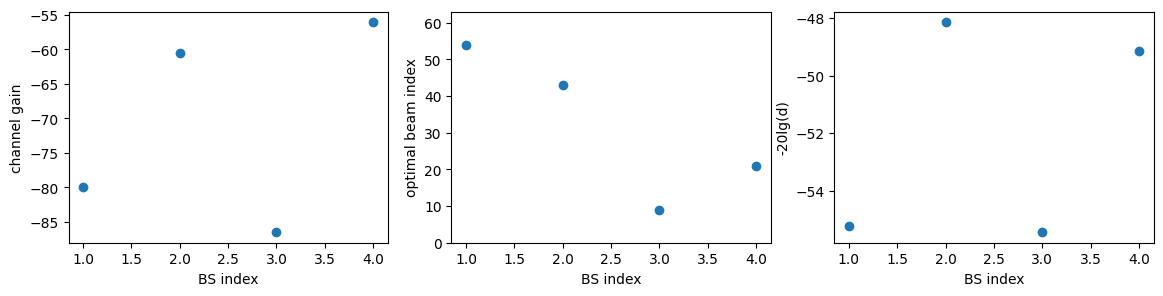

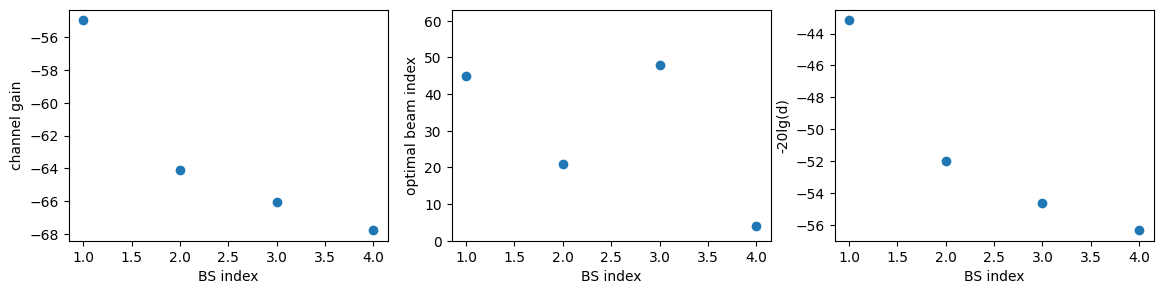

In [11]:
for i, veh in enumerate(trajectoryInfo[see_scene].keys()):
    if i not in list(range(0,200,10)):
        continue
    veh_pos = trajectoryInfo[see_scene][veh]['pos']
    veh_h = trajectoryInfo[see_scene][veh]['h']
    tx1_position=np.array([270,270])
    tx2_position=np.array([-270,270])
    tx3_position=np.array([270,-270])
    tx4_position=np.array([-270,-270])
    
    dis1 = np.linalg.norm(veh_pos-tx1_position)
    dis2 = np.linalg.norm(veh_pos-tx2_position)
    dis3 = np.linalg.norm(veh_pos-tx3_position)
    dis4 = np.linalg.norm(veh_pos-tx4_position)
    zz = np.array([dis1, dis2, dis3, dis4] )
    zz = -20*np.log10(zz)
    plt.figure(figsize=(14,3))
    plt.subplot(1,3,1)
    plt.xlabel('BS index')
    plt.ylabel('channel gain')
    yy = 20*np.log10(np.abs(np.dot(veh_h,DFT_matrix)).max(axis=-1)+1e-15)
    plt.scatter([1,2,3,4],yy)
    plt.subplot(1,3,2)
    plt.xlabel('BS index')
    plt.ylabel('optimal beam index')
    yy1 = np.abs(np.dot(veh_h,DFT_matrix)).argmax(axis=-1)
    plt.scatter([1,2,3,4],yy1)
    plt.ylim([0,63])
    plt.subplot(1,3,3)
    plt.xlabel('BS index')
    plt.ylabel('-20lg(d)')
    plt.scatter([1,2,3,4],zz)
    print(veh,veh_pos)

In [12]:
veh = 5.36
veh_pos = trajectoryInfo[500.0][veh]['pos']
veh_h = trajectoryInfo[500.0][veh]['h']

In [8]:
tx1_position=np.array([270,270])
tx2_position=np.array([-270,270])
tx3_position=np.array([270,-270])
tx4_position=np.array([-270,-270])

dis1 = np.linalg.norm(veh_pos-tx1_position)
dis2 = np.linalg.norm(veh_pos-tx2_position)
dis3 = np.linalg.norm(veh_pos-tx3_position)
dis4 = np.linalg.norm(veh_pos-tx4_position)
zz = np.array([dis1, dis2, dis3, dis4] )
zz = -20*np.log10(zz)

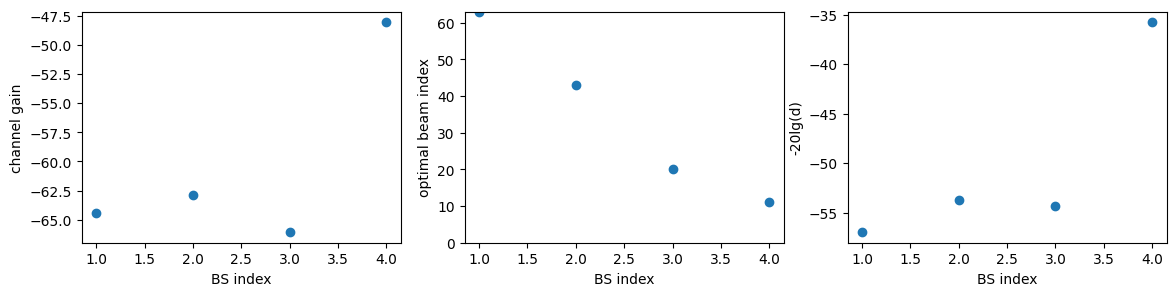

In [9]:
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
plt.xlabel('BS index')
plt.ylabel('channel gain')
yy = 20*np.log10(np.abs(np.dot(veh_h,DFT_matrix)).max(axis=-1)+1e-15)
plt.scatter([1,2,3,4],yy)
plt.subplot(1,3,2)
plt.xlabel('BS index')
plt.ylabel('optimal beam index')
yy1 = np.abs(np.dot(veh_h,DFT_matrix)).argmax(axis=-1)
plt.scatter([1,2,3,4],yy1)
plt.ylim([0,63])
plt.subplot(1,3,3)
plt.xlabel('BS index')
plt.ylabel('-20lg(d)')
plt.scatter([1,2,3,4],zz)

In [ ]:
# 5.9GHz   channel_gain(dB) distance
(-99.5053768157959, 382.233)
(-80.97159385681152, 45.251938)
(-102.32035636901855, 528.44543)
(-103.65667343139648, 616.4306) 

In [ ]:
# 2*5.9GHz
(-109.67726707458496, 616.4306)

In [ ]:
# 4*5.9GHz
(-115.6978702545166, 616.4306)

In [ ]:
# 1 Hz
(91.76036834716797, 616.4306)

In [ ]:
a(f) = -6.02*log2(f) + 147.53875497221685

In [12]:
# 5.9GHz
a = -47.85881323471679
alpha = 2

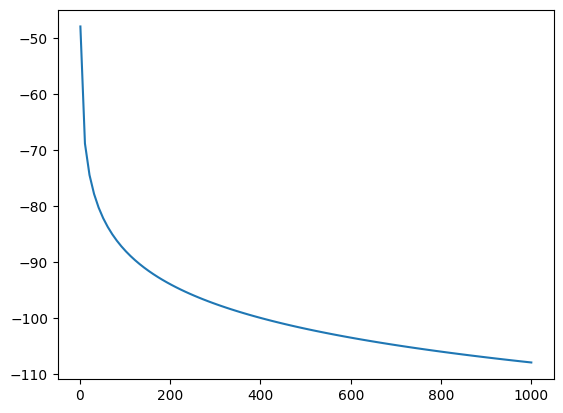

In [13]:
plt.figure()
ddd = np.linspace(1,1000,100)
plt.plot(ddd,a-10*alpha*log10(ddd))

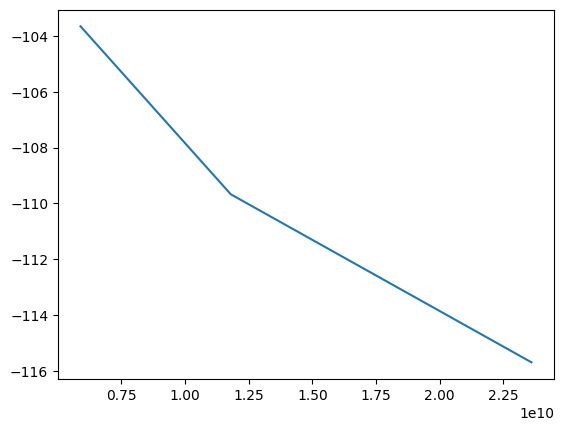

In [16]:
plt.figure()
plt.plot(5.9e9*np.array([1,2,4]),[-103.65667343139648,-109.67726707458496,-115.6978702545166])

In [17]:
-115.6978702545166+109.67726707458496

-6.020603179931641

In [ ]:
# 频率翻倍 -> dB -6.020603179931641

In [18]:
log2 = np.log2
log2(5.9e9)*6.02

195.39756820693364

In [22]:
20*log10(2)

6.020599913279624

In [ ]:
# 5.9GHz   channel_gain(dB) distance
(-99.5053768157959, 382.233)
(-80.97159385681152, 45.251938)
(-102.32035636901855, 528.44543)
(-103.65667343139648, 616.4306) 

In [33]:
-103.65667343139648+20*log10(5.9e3)+20*log10(616.4306e-3)

-32.44194941393702